In [1]:
!nvidia-smi

Mon Apr 23 21:31:24 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:26:00.0  On |                  N/A |
| 28%   52C    P2    62W / 200W |   1082MiB /  8118MiB |     39%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# importing data science libraries
import pandas as pd

fraud_dataset = pd.read_csv('../data/nonames.csv')
print("There are ", len(fraud_dataset), " samples")
print(fraud_dataset.shape)
print(fraud_dataset.head(10))
print(fraud_dataset.describe())

There are  6362620  samples
(6362620, 12)
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64      170136.00       160296.36             0.0   
1     1   1864.28       21249.00        19384.72             0.0   
2     1    181.00         181.00            0.00             0.0   
3     1    181.00         181.00            0.00         21182.0   
4     1  11668.14       41554.00        29885.86             0.0   
5     1   7817.71       53860.00        46042.29             0.0   
6     1   7107.77      183195.00       176087.23             0.0   
7     1   7861.64      176087.23       168225.59             0.0   
8     1   4024.36        2671.00            0.00             0.0   
9     1   5337.77       41720.00        36382.23         41898.0   

   newbalanceDest  isFraud  CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0            0.00        0        0         0      0        1         0  
1            0.00        0        0         0      0        1

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
RANDOM_SEED = 42

In [5]:
X_train, X_test = train_test_split(fraud_dataset, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
# y_train = X_train["isFraud"].copy(deep=True)
X_train.pop("isFraud")
print("X_train: ", X_train.shape)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
y_test = X_test["isFraud"].copy(deep=True)
X_test.pop("isFraud")
print("X_test: ", X_test.shape)

X_train:  (5090096, 12)
X_train:  (5090096, 11)
X_train:  (4072076, 11)
X_val:  (1018020, 11)
X_test:  (1272524, 12)
X_test:  (1272524, 11)


In [6]:
input_shape = X_train.shape[1]

hidden_layer = [10, 8, 4]
input_layer = Input(shape=(input_shape,))
encoder1 = Dense(hidden_layer[0], activation="softmax")(input_layer)
encoder2 = Dense(hidden_layer[1], activation="softmax")(encoder1)
encoder3 = Dense(hidden_layer[2], activation="softmax")(encoder2)
decoder1 = Dense(hidden_layer[2], activation="softmax")(encoder3)
decoder2 = Dense(hidden_layer[1], activation="softmax")(decoder1)
decoder3 = Dense(input_shape, activation="softmax")(decoder2)
autoencoder = Model(inputs=input_layer, outputs=decoder3)

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 11)                99        
Total para

In [8]:
nb_epoch = 200
batch_size = 1000
# using mean squared error
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="../saved/basicAE3.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111641577.0518 - acc: 0.3226 - val_loss: 4259460097290.5767 - val_acc: 0.3714
Epoch 2/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111607123.9136 - acc: 0.3720 - val_loss: 4259460097290.5767 - val_acc: 0.3714
Epoch 3/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111615848.4072 - acc: 0.3720 - val_loss: 4259460097290.5767 - val_acc: 0.3714
Epoch 4/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111610356.8770 - acc: 0.3720 - val_loss: 4259460097290.5767 - val_acc: 0.3714
Epoch 5/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111613094.7881 - acc: 0.3720 - val_loss: 4259460097290.5767 - val_acc: 0.3714
Epoch 6/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111616598.7744 - acc: 0.3720

Epoch 50/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111585286.0259 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 51/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111591606.3340 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 52/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111587684.4185 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 53/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111586618.8672 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 54/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111593338.1772 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 55/200
4072076/4072076 [==============================] - 25s 6us/step - loss: 4202111588346.2041 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.371

4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111598548.2563 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 100/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111603166.3340 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 101/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111597542.4458 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 102/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111589965.6470 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 103/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111588346.4619 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 104/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111589355.1050 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 

Epoch 148/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111583065.8267 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 149/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111594161.6753 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 150/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111590045.9883 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 151/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111592120.6982 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 152/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111588926.8755 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 153/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 4202111587558.2422 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc:

Epoch 197/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111586080.1689 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 198/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111589394.7607 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 199/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111592245.8452 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714
Epoch 200/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 4202111589002.0669 - acc: 0.3720 - val_loss: 4259460075917.7622 - val_acc: 0.3714


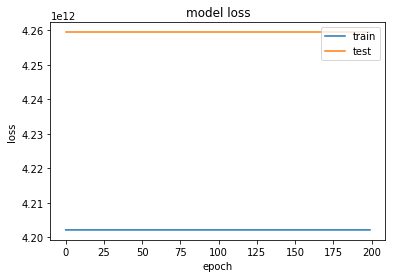

In [9]:
# importing visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

autoencoder = load_model('../saved/basicAE3.h5')

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [10]:
import numpy as np

predictions = autoencoder.predict(X_test)
# calculate my own MSE
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,1.272524e+06,1.272524e+06
mean,4.273575e+12,1.273060e-03
std,7.157309e+13,3.565727e-02
min,1.370081e+01,0.000000e+00
25%,3.821978e+08,0.000000e+00
50%,2.526166e+10,0.000000e+00
75%,5.597485e+11,0.000000e+00
max,2.300391e+16,1.000000e+00
